# Алгоритм K-средних

Алгоритм основан на следующей идее: давайте разместим центры кластеров в случайных местах, а потом будем их двигать таким образом, чтобы "центры" совпали с областями, где точек больше всего. Визуализация этого алгоритма отображена на gif:

![kmeans8](https://248006.selcdn.ru/public/DS.%20Block%202.%20M7/kmeans8.gif)

Формальное описание алгоритма обучения модели:

1. Выберите количество кластеров k. Количество кластеров можно задать с помощью эксперта (который скажет, сколько должно быть кластеров в датасете), либо выбрать количество кластеров интуитивно (я рекомендую всегда использовать количество кластеров $k=2$). О том, как выбирать количество кластеров автоматически, а не вручную, мы поговорим в следующем уроке
1. Инициализировать *случайными значениями* координаты кластеров (они называются центроиды)
1. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе и раскрасить точку в цвет этого кластера
1. Переместить каждый центроид в центр выборки соответствующих ему элементов. Центр выборки находится как *среднее* всех элементов, входящих в выборку (отсюда и вторая часть названия алгоритма - усреднение).
1. Повторять до выполнения одного из условий
    1. Алгоритм сошелся (положение центроидов не меняется)
    1. Превышено максимально допустимое число итераций
    
Как делать предсказания для входной точки $x$? Очень просто - нужно найти среди кластеров тот, который ближе всего к точке $x$ - например, по евклидовой метрике близости, с которой мы познакомились в первом уроке этого модуля. Какой кластер ближе всего, туда и стоит отнести нашу точку $x$.

Для иллюстрации работы алгоритма, загрузим датасет для кластеризации

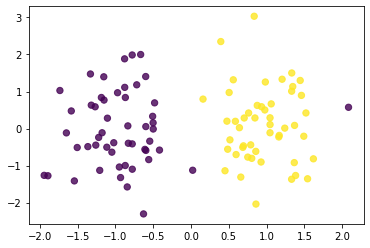

In [3]:
import pickle
import numpy as np

# данные получены с помощью функции make_classification 
with open('clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)

X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.show()

В библиотеке sklearn уже есть готовая реализация алгоритма `sklearn.cluster.KMeans` - давайте просто применим её к нашим данным. Точки разобъём на два кластера (параметр *n_clusters=2*):

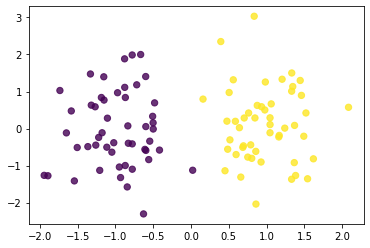

In [4]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(X)

plt.scatter(X[:, 0], X[:, 1], s=40, c=kmeans_model.labels_, marker='o', alpha=0.8, label='data')
plt.show()

## Недостатки K-Means

Во-первых, вычислительная сложность - элементов может быть очень много и нахождение расстояний может отнять значительное время. В этом случае применяют вычисление центроидов по подвыборке, такая модификация получила название **mini batch K-means**

Во-вторых - где лучше инициализировать центроиды, как задать им начальное положение? От начальной инициализации зависит то, куда сойдётся алгоритм и как быстро он это сделаем. Для решения этой проблемы придумали такую эвристику: давайте запускать алгоритм несколько раз и запоминать, куда попали центроиды. После нескольких запусков есть два варианта: усреднить центроиды или выбрать лучший по метрикам качества.

# Выбор количества кластеров $k$ в алгоритме *k-means*

Существенный недостаток алгоритма заключается в необходимости до начала эксперимента выбирать количество кластеров. В этом уроке мы научимся выбирать количество кластеров $K$ автоматически.

Мы будем подходить к выбору оптимального количества кластеров, как к задаче оптимизации - выберем метрику качества кластеризации, которая зависит от параметра $K$ найдём как-нибудь, при каком значении $K$ у нас самая лучшая кластеризация. Хорошей метрикой качества является т.н. внутрикластерное расстояние.

Для подбора вводится метрика качества кластеризации с центроидами $\mu_k: \forall k=1,\ldots,K$, которая измеряет внутрикластерное расстояние - насколько хорошо центр, который мы выбрали, совпадает с "идеальным" центром кластера
$$
J(C) = \sum_{k=1}^{K}\sum_{j \in C_k} \mid x_j - \mu_k \mid \rightarrow min
$$

В этой формуле
* $\mu_k$ - координаты центроида кластера под номером $k$, количество кластеров $k$
* $x_j$ - объект под номером $j$, принадлежащий кластеру под номером $k$
* $\mid x_j - \mu_k \mid$ - евклидово расстояние (см. первый урок) от примера $x_j$ до центроида $\mu_k$

Очевидно, что эта метрика достигает оптимума в точке, где количество соответствует количеству элементов в выборке. Однако, это вырожденный случай - на практике применяют эвристику "метод локтя", которая предполагает выбор точки, в которой резко снижается динамика изменения $J(C)$:
$$
D(K) =\frac{\mid J(C_{k+1}) - J(C_{k}) \mid}{\mid J(C_{k}) - J(C_{k-1}) \mid} \rightarrow \min
$$

Пример на картинке:
![elbow_method](https://248006.selcdn.ru/public/DS.%20Block%202.%20M7/elbow_method.png)

In [5]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances

metrics = []
MAX_CLUSTERS = 7
for cluster_num in range(1, MAX_CLUSTERS):
    kmeans_model = KMeans(n_clusters=cluster_num, random_state=99).fit(X)
    centroids, labels = kmeans_model.cluster_centers_, kmeans_model.labels_
    metric = 0
    for centroid_label in range(cluster_num):
        metric += euclidean_distances(
            X[labels==centroid_label],
            centroids[centroid_label,:].reshape(1,-1)
        ).sum(axis=0)[0]
    print("cluster_num %s, metric %s" % (cluster_num, metric))
    metrics.append(metric)

cluster_num 1, metric 135.92762259869988
cluster_num 2, metric 92.34245055263457
cluster_num 3, metric 74.52323397050206
cluster_num 4, metric 60.75176580321338
cluster_num 5, metric 54.86662031054898
cluster_num 6, metric 49.745770433790256


best cluster num: 2


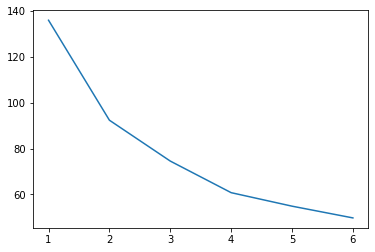

In [6]:
D = []
for i in range(0, len(metrics)-1):
    d = abs(metrics[i+1]-metrics[i])/abs(metrics[i]-metrics[i-1])
    D.append(d)
print("best cluster num: %s" % (np.argmin(D)+1))

plt.plot([i+1 for i in range(len(metrics))], metrics)
plt.show()

Визуально заметно, что в точке $k=2$ в графике наблюдается перегиб - это и есть тот самый "локоть". Значит, оптимальное количество кластеров для нашего датасета $k=2$

#  Подготовка

## Импорт библиотек

In [4]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font", size=18) # для увеличения шрифта подписей графиков

# импортируем модуль, отвечающий за кластеризацию
from sklearn.cluster import KMeans

## Загрузка данных

In [2]:
# загружаем данные
houses = pd.read_csv("houses.csv")
houses.head()

,dim_1,dim_2,level,price
0,29,28,luxury,2212.0
1,28,29,luxury,2203.0
2,6,9,basic,254.0
3,5,9,basic,242.0
4,6,6,basic,195.0


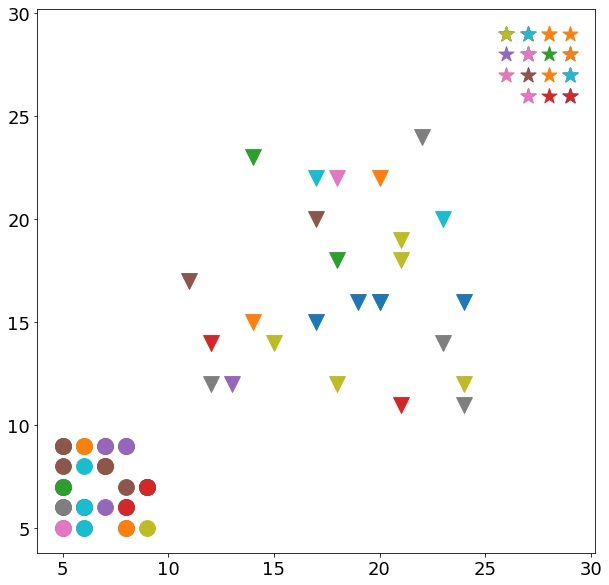

In [3]:
fig = plt.figure(figsize=(10, 10)) # создаем картинку

markers = {"basic": "o", "medium": "v", "luxury": "*"}
for d1, d2, l in zip(houses.dim_1, houses.dim_2, houses.level):
    plt.scatter(d1, d2, s=250, marker=markers[l])

# отображаем картинку
plt.show()

#  Создание модели

## Самописная реализация алгоритма K-средних

In [7]:
import pickle
import numpy as np

# данные получены с помощью функции make_classification 
with open('clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)

X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

шаг 0, смещение кластеров: [1.2443364059034996, 1.3747461461255697]
шаг 1, смещение кластеров: [0.23870886888277792, 0.2989548302720647]
шаг 2, смещение кластеров: [0.13793461632692094, 0.13352534968206672]
шаг 3, смещение кластеров: [0.06396478904973678, 0.060600974480894285]
шаг 4, смещение кластеров: [0.08583566647344554, 0.07955030622457585]
шаг 5, смещение кластеров: [0.0, 0.0]


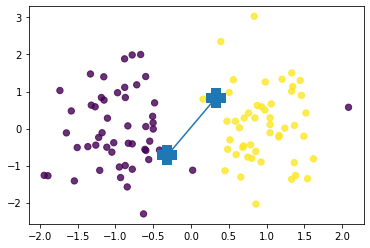

In [8]:
import numpy as np
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt

%matplotlib inline

def random_centroids_selection(X, n, k):
    """Рандомно инициализируем центр кластера"""
    result = []
    for obj_id in np.random.randint(0, n, size=k):
        result.append(X[obj_id, :])
    return result

def eval_weight_evolution(centroid_objects_prev, centroid_objects, k):
    """Вычисляем, как сдвинулись центры за один шаг алгоритма"""
    result = []
    for i in range(k):
        dist = distance.euclidean(
            centroid_objects_prev[i],
            centroid_objects[i]
        )
        result.append(dist)
    return result

def eval_centroids(X, k, cluster_lables):
    """Вычисляем новые центроиды с методом усреднения координат"""
    result = []
    for i in range(k):
        new_centroid = X[cluster_lables==i].mean(axis=0)
        result.append(new_centroid)
    return result

def eval_cluster_lables(X, centroid_objects):
    """Вычисляем метки кластеров"""
    # формируем матрицу (n x k), которая содержит расстояние от каждого объекта до каждого центроида
    cluster_distance = euclidean_distances(X, centroid_objects)
    # находим минимальное расстояние в каждой строчке - это будет кластер объекта
    cluster_lables = cluster_distance.argmin(axis=1)
    return cluster_lables

def k_means(X:np.array, k: int=2, eps: float=0.001, num_iteration: int=10) -> np.array:
    """Алгоритм К-средних
    
    :param X: обучающая выборка
    :param k: количество кластеров
    """
    try:
        n, m = X.shape
    except ValueError:
        print("Обучающая выборка должна быть двумерным массивом (n, m) гдк m - размер выборки")
    # инициализируем центроиды случайным элементом выборки
    centroid_objects = random_centroids_selection(X, n, k)
    centroid_objects_prev = [np.zeros(m) for i in range(k)]
    # расстояние между предыдущим и текущим положением каждого центроида
    weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
    step = 0
    # условие остановки: центроиды не изменили своего положения
    # повторяем до выполнения условия остановки
    while sum(weight_evolution[i] > eps for i in range(k))!=0 and step < num_iteration:
        # иначе можно прострелить себе ногу =0
        centroid_objects_prev = centroid_objects.copy()
        # вычисляем метки кластеров
        cluster_lables = eval_cluster_lables(X, centroid_objects)
        # усредняем координаты объектов каждого кластера - это новое положение центроида
        centroid_objects = eval_centroids(X, k, cluster_lables)
        # вычисляем расстояние между центроидами на соседних итерациях
        weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
        print("шаг %s, смещение кластеров: %s" % (step, weight_evolution))
        # обновлённые кластера
        step += 1
    return np.vstack(centroid_objects), cluster_lables
    

centroids, labels = k_means(X, k=2, num_iteration=10)

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.plot(centroids[:, 0], centroids[:, 1], marker='+', mew=10, ms=20)
plt.show()

## Создание модели кластеризации К-средних

In [5]:
# выгружаем признаки в отдельную переменную
X = houses[["dim_1", "dim_2"]]

# создаем модель для кластеризации
clust = KMeans(n_clusters=3).fit(X)

In [6]:
# смотрим центры кластеров
[c1, c2, c3] = clust.cluster_centers_

clust.cluster_centers_

array([[ 6.76744186,  7.1627907 ],
       [27.42424242, 27.51515152],
       [18.5       , 16.45833333]])

##  Визуализация наших кластеров

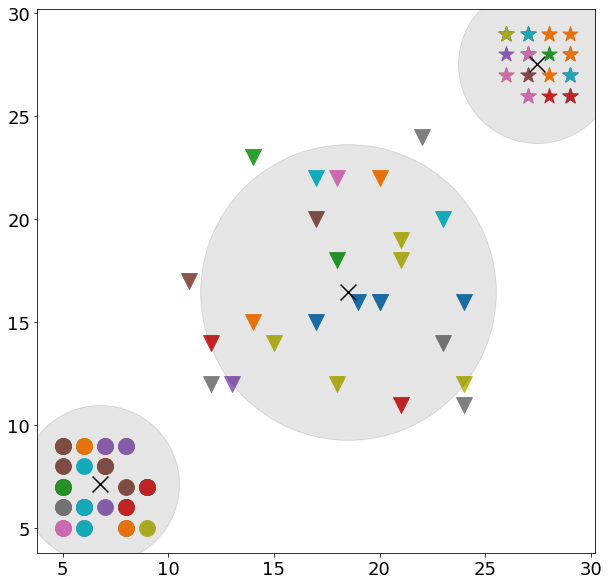

In [7]:
fig = plt.figure(figsize=(10, 10)) # создаем картинку

markers = {"basic": "o", "medium": "v", "luxury": "*"}
for d1, d2, l in zip(houses.dim_1, houses.dim_2, houses.level):
    plt.scatter(d1, d2, s=250, marker=markers[l])
    
# добавляем информацию о центрах кластеров
plt.scatter(c1[0], c1[1], s=250, marker="x", c="black")
plt.scatter(c1[0], c1[1], s=250 * 1e2, c="black", alpha=0.1)

plt.scatter(c2[0], c2[1], s=250, marker="x", c="black")
plt.scatter(c2[0], c2[1], s=250 * 1e2, c="black", alpha=0.1)

plt.scatter(c3[0], c3[1], s=250, marker="x", c="black")
plt.scatter(c3[0], c3[1], s=250 * 3.5e2, c="black", alpha=0.1)

# отображаем картинку
plt.show()